In [3]:
import kagglehub
path = kagglehub.dataset_download("denkuznetz/traffic-accident-prediction")
print("Path to dataset files:", path)

Path to dataset files: /home/omnia/.cache/kagglehub/datasets/denkuznetz/traffic-accident-prediction/versions/1


In [4]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for model building, preprocessing, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
# Import SMOTE from imblearn to address class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
# Set a modern theme for plots
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.2)

In [5]:
# Load the dataset
#  'traffic_accident_prediction.csv' is in  working directory
df = pd.read_csv('traffic_accident_prediction.csv')

# Display the first 5 rows of the dataset to get an overview
print("First 5 rows of the dataset:")
print(df.head())

# Print dataset information to check data types and non-null counts
print("\nDataset Information:")
print(df.info())

# Display descriptive statistics for numerical features
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values in each column
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

First 5 rows of the dataset:
  Weather   Road_Type Time_of_Day  Traffic_Density  Speed_Limit  \
0   Rainy   City Road     Morning              1.0        100.0   
1   Clear  Rural Road       Night              NaN        120.0   
2   Rainy     Highway     Evening              1.0         60.0   
3   Clear   City Road   Afternoon              2.0         60.0   
4   Rainy     Highway     Morning              1.0        195.0   

   Number_of_Vehicles  Driver_Alcohol Accident_Severity      Road_Condition  \
0                 5.0             0.0               NaN                 Wet   
1                 3.0             0.0          Moderate                 Wet   
2                 4.0             0.0               Low                 Icy   
3                 3.0             0.0               Low  Under Construction   
4                11.0             0.0               Low                 Dry   

  Vehicle_Type  Driver_Age  Driver_Experience Road_Light_Condition  Accident  
0          Car

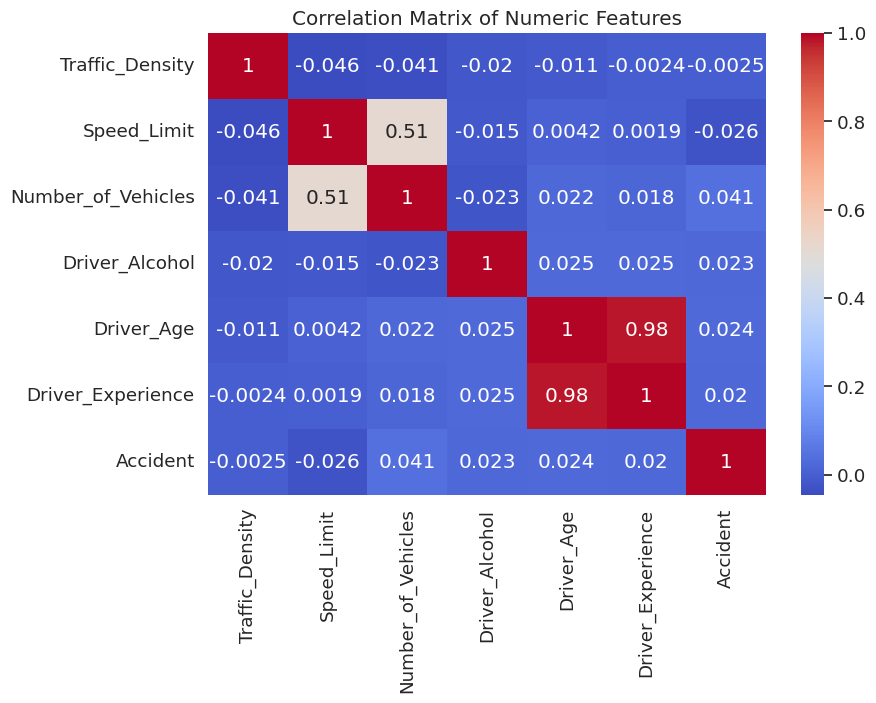

In [6]:
#  Data Visualization

# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=[np.number])

# Create a heatmap to visualize the correlation matrix of numeric features
plt.figure(figsize=(9,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()



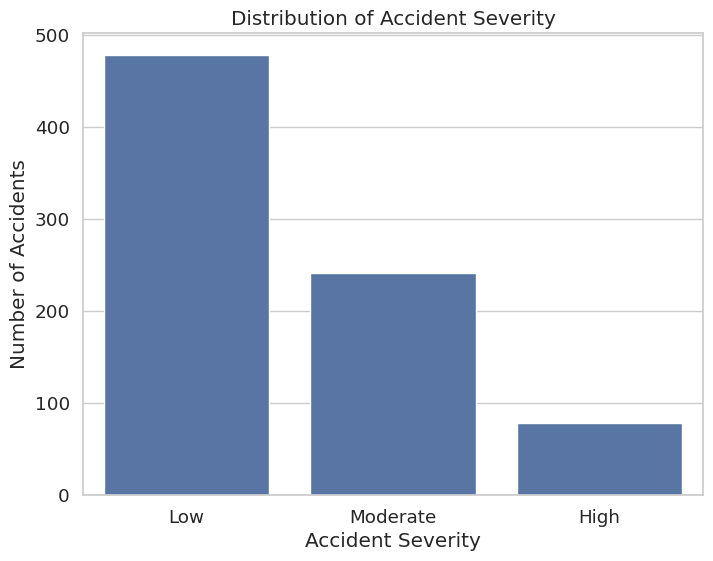

In [7]:
#  Data Visualization


# Plot the distribution of the target variable "Accident_Severity"
plt.figure(figsize=(8, 6))
sns.countplot(x='Accident_Severity', data=df, order=['Low', 'Moderate', 'High'])
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Number of Accidents')
plt.show()



/tmp/ipykernel_2099590/899814740.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Road_Light_Condition', data=df, palette=custom_colors)


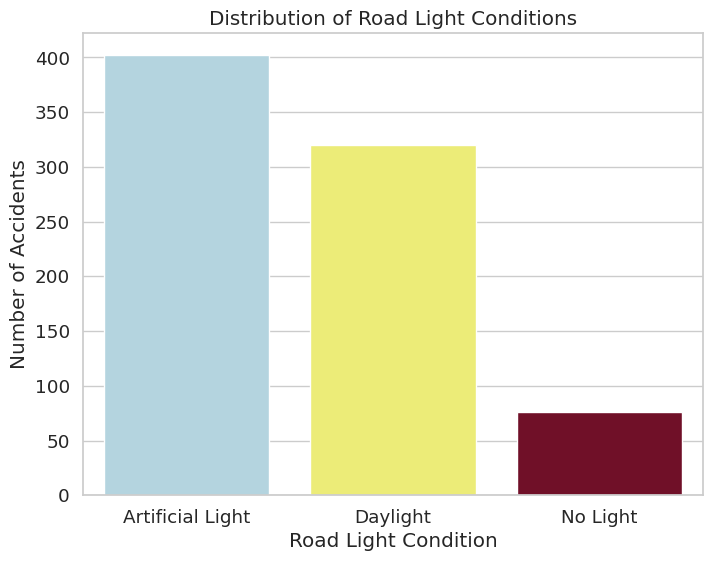

In [8]:

custom_colors = ['#ADD8E6', '#FFFF65', '#800020']

plt.figure(figsize=(8, 6))
sns.countplot(x='Road_Light_Condition', data=df, palette=custom_colors)
plt.title('Distribution of Road Light Conditions')
plt.xlabel('Road Light Condition')
plt.ylabel('Number of Accidents')
plt.show()


In [9]:
from scipy.stats import chi2_contingency
# not only light condition
contingency_table = pd.crosstab(df['Road_Light_Condition'], df['Accident'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("p-value =", p_value)
# high value --> not related 

p-value = 0.9761393373712018


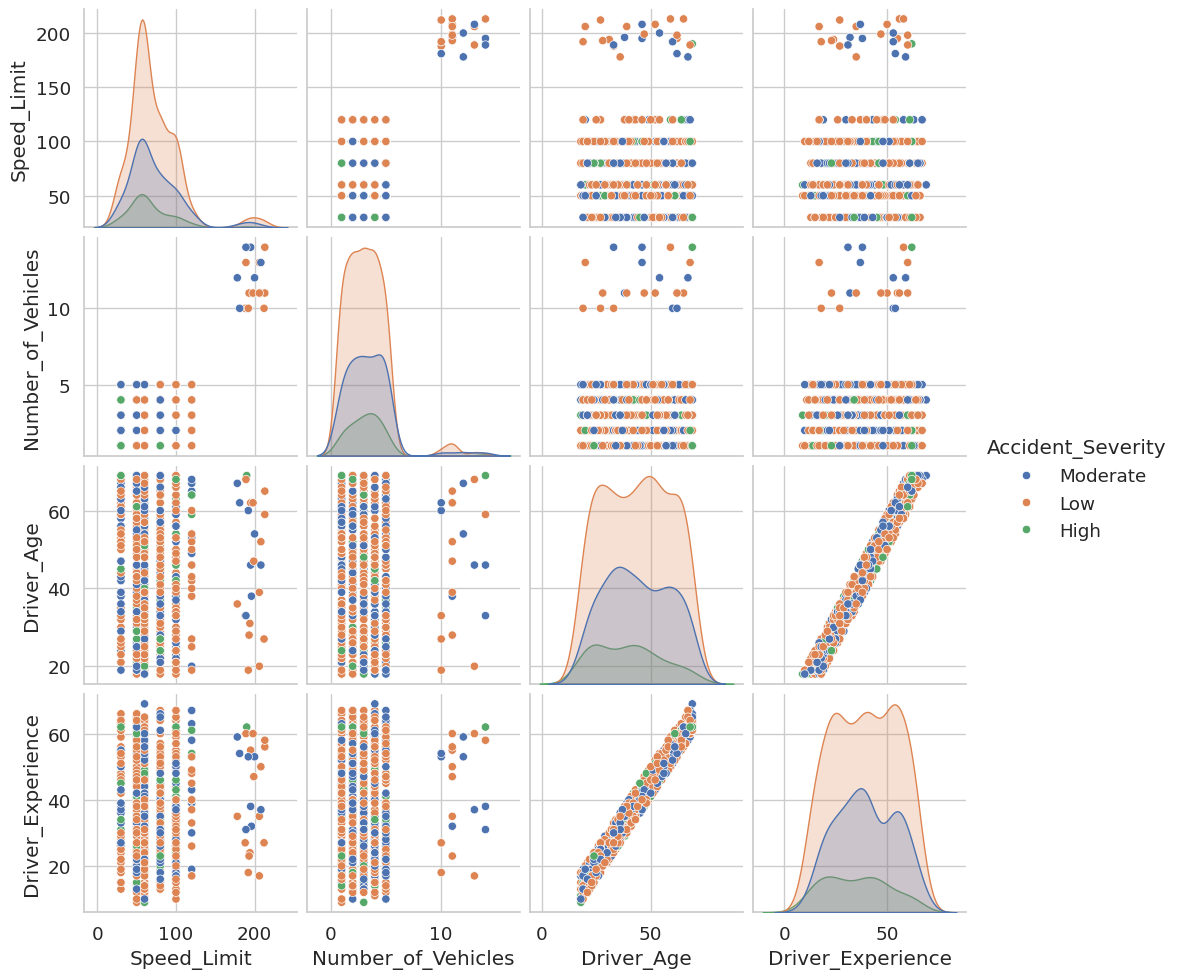

In [10]:

# Create a pairplot for selected numerical features along with the target variable
selected_features = ['Speed_Limit', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Experience']
sns.pairplot(df[selected_features + ['Accident_Severity']], hue='Accident_Severity')
plt.show()





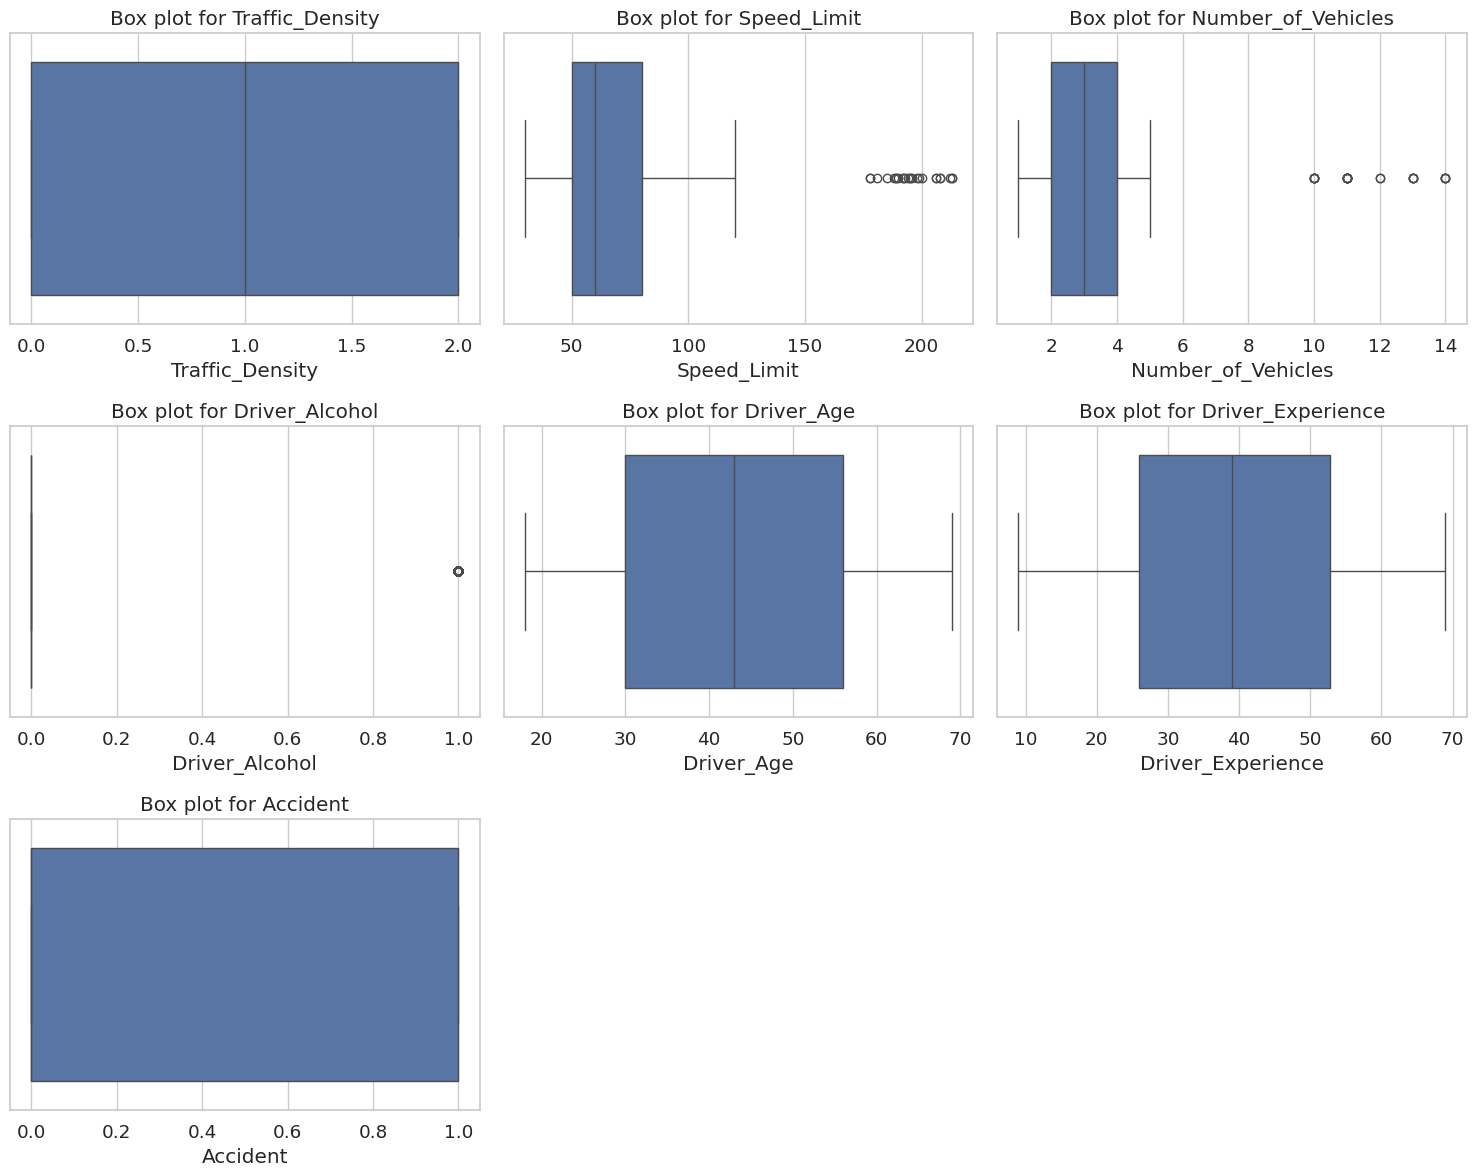

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# double check ouliers
# Step: Visualize outliers using Box Plot for each numeric column
# Create a box plot for each numeric column in the DataFrame
plt.figure(figsize=(15, 12))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Loop through each numeric column and plot the box plot
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  #  rowsو columns for the subplots (adjust as needed)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box plot for {col}')

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()


In [12]:
# Data Preprocessing

# Handle missing values by dropping rows (you can use imputation if needed)
#df = df.dropna() # not preferred
# Step 1: Handle missing values (Imputation)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['Weather', 'Road_Type', 'Time_of_Day', 'Road_Condition', 'Vehicle_Type', 'Road_Light_Condition','Accident_Severity']

# Impute missing values in numeric columns with the median
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute missing values in categorical columns with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# # Step 2: Handle Outliers using IQR method
# Q1 = df[numeric_cols].quantile(0.25)
# Q3 = df[numeric_cols].quantile(0.75)
# IQR = Q3 - Q1
# df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 3: Label encode categorical variables (instead of One-Hot Encoding)
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Step 4: Encode the target variable
df['Accident'] = label_encoder.fit_transform(df['Accident'])

# Step 5: Separate features and target
X = df.drop('Accident', axis=1)
y = df['Accident']

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Step 7: Scale the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Check dataset info and stats
print(df.head())
print("\nDataset Information After Encoding:")
print(df.info())
print("\nDescriptive Statistics After Encoding:")
print(df.describe())
print("\nMissing Values After Preprocessing:")
print(df.isnull().sum())


   Weather  Road_Type  Time_of_Day  Traffic_Density  Speed_Limit  \
0        2          0            2              1.0        100.0   
1        0          3            3              1.0        120.0   
2        2          1            1              1.0         60.0   
3        0          0            0              2.0         60.0   
4        2          1            2              1.0        195.0   

   Number_of_Vehicles  Driver_Alcohol  Accident_Severity  Road_Condition  \
0                 5.0             0.0                  1               3   
1                 3.0             0.0                  2               3   
2                 4.0             0.0                  1               1   
3                 3.0             0.0                  1               2   
4                11.0             0.0                  1               0   

   Vehicle_Type  Driver_Age  Driver_Experience  Road_Light_Condition  Accident  
0             1        51.0               48.0       

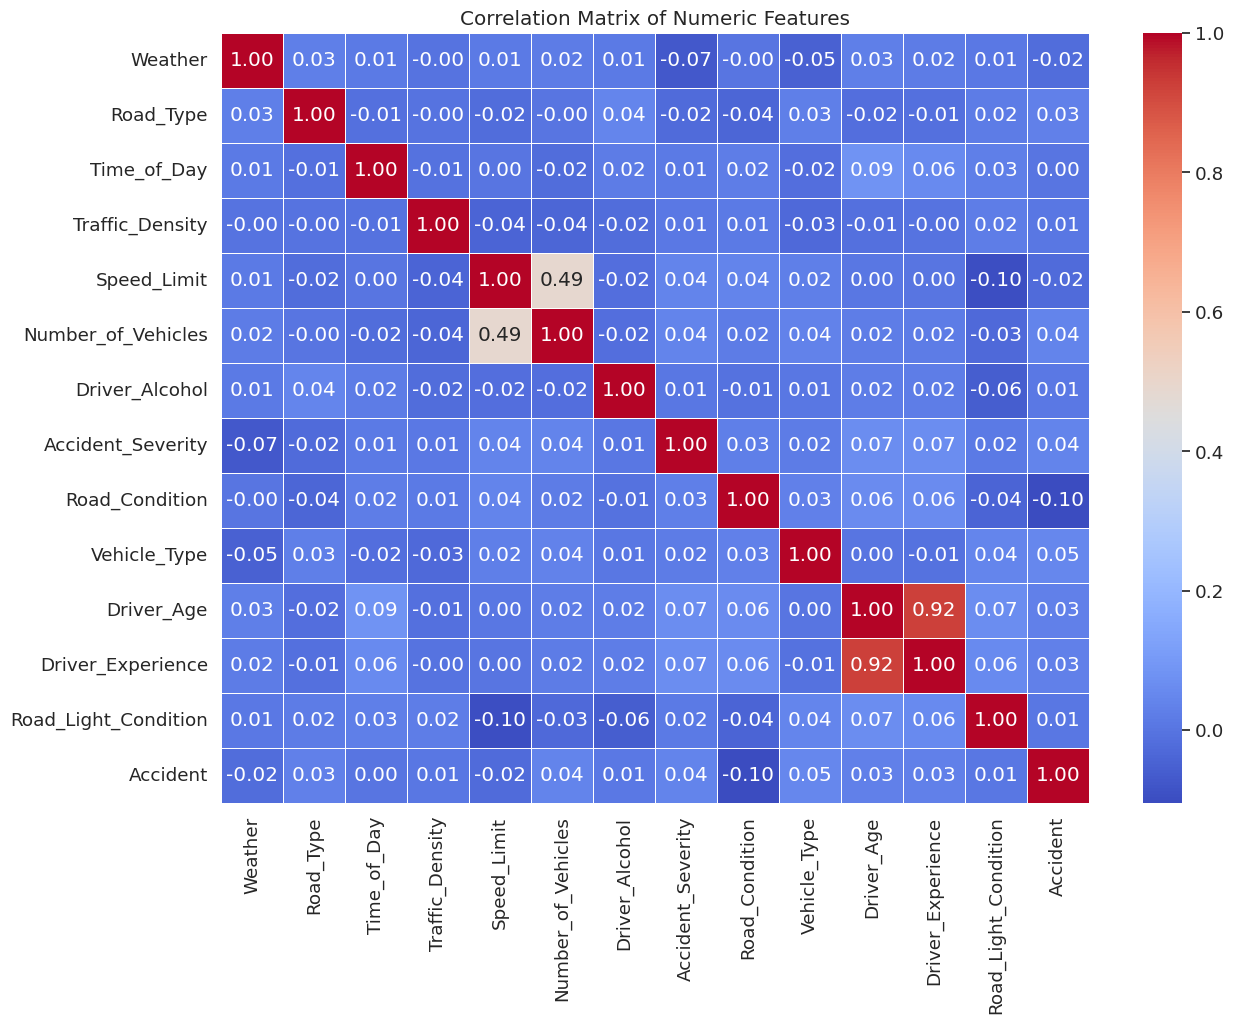

/tmp/ipykernel_2099590/266713804.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Accident_Severity', data=df,  palette='Set2')


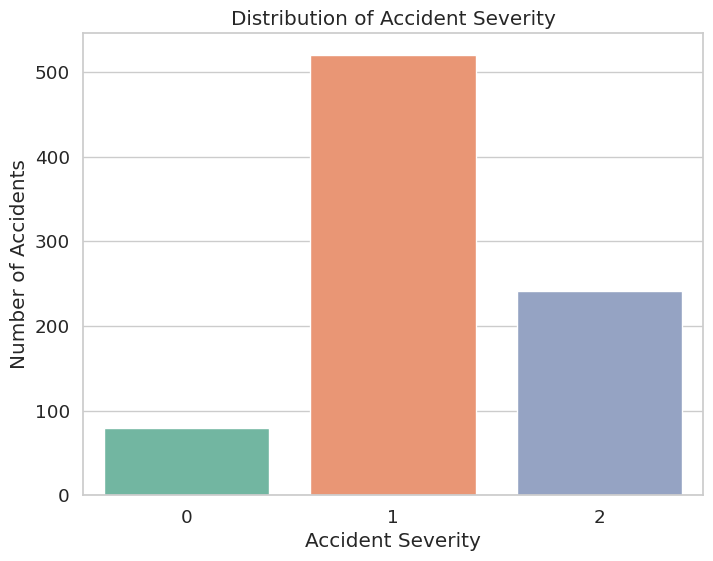

/tmp/ipykernel_2099590/266713804.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Road_Light_Condition', data=df, palette='Set3')


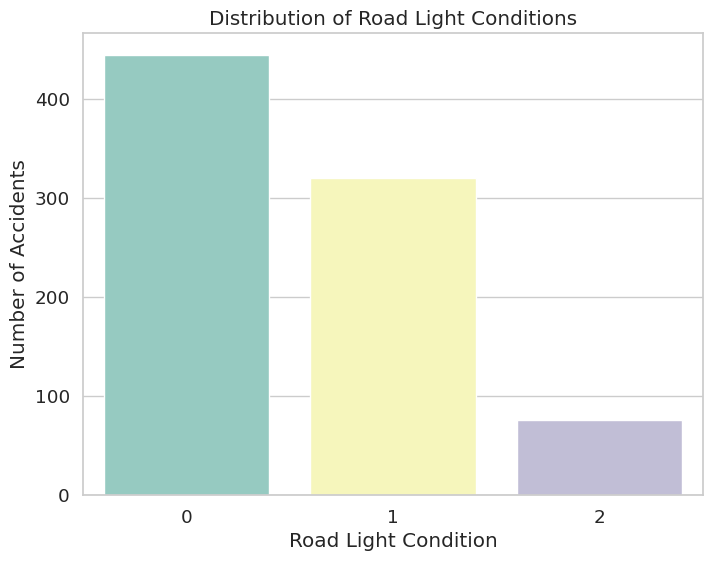

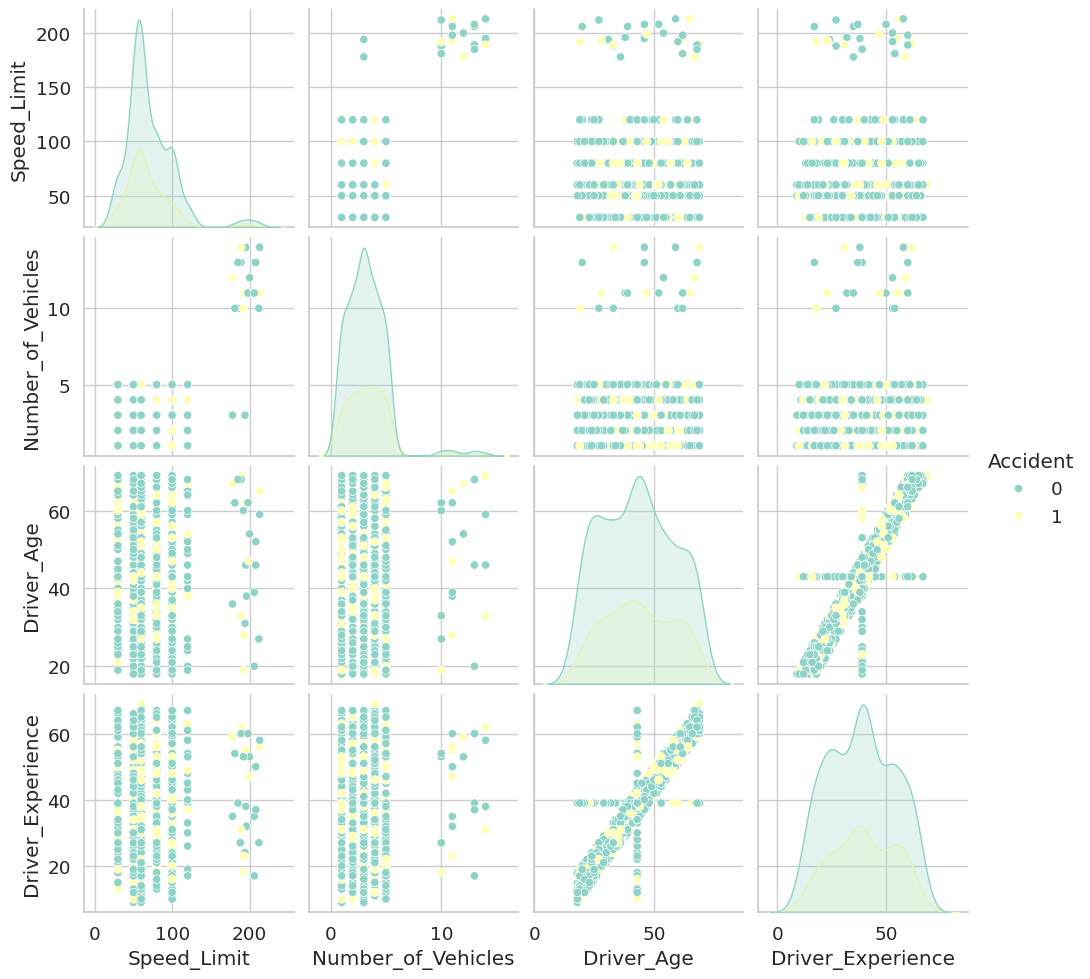

In [13]:
#visualization after preprocessing
# Step 1: Correlation Matrix Heatmap
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(14,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Step 2: Distribution of Accident Severity

plt.figure(figsize=(8, 6))
sns.countplot(x='Accident_Severity', data=df,  palette='Set2')
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Number of Accidents')
plt.show()
# Step 3: Distribution of Road Light Condition
plt.figure(figsize=(8, 6))
sns.countplot(x='Road_Light_Condition', data=df, palette='Set3')
plt.title('Distribution of Road Light Conditions')
plt.xlabel('Road Light Condition')
plt.ylabel('Number of Accidents')
plt.show()

# Step 4: Pairplot for selected features
selected_features = ['Speed_Limit', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Experience']

# Show pairplot for selected numerical features along with target variable
sns.pairplot(df[selected_features + ['Accident']], hue='Accident', palette='Set3')
plt.show()





In [42]:
#  Model Selection and Initial Training



# Feature selection based on correlation with 'Accident'
threshold = 0.02
correlation_matrix = df.corr()
high_corr_features = correlation_matrix.index[abs(correlation_matrix["Accident"]) > threshold].tolist()
high_corr_features.remove("Accident")

# Selected features and target
X_selected = df[high_corr_features]
Y = df["Accident"]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.2, random_state=42)

# Print the split ratio
total = len(Y)
print(f"🔹 Training Set: {len(y_train)} samples ({(len(y_train)/total)*100:.2f}%)")
print(f"🔹 Test Set:     {len(y_test)} samples ({(len(y_test)/total)*100:.2f}%)")

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=45, class_weight='balanced')
}

# Train models and print accuracy
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} - Accuracy on Test Set: {acc:.4f}")




🔹 Training Set: 672 samples (80.00%)
🔹 Test Set:     168 samples (20.00%)
Logistic Regression - Accuracy on Test Set: 0.6964
Decision Tree - Accuracy on Test Set: 0.6250
Random Forest - Accuracy on Test Set: 0.7024


In [34]:

print(df.isnull().sum())
print(df['Accident_Severity'].value_counts())
print(X_train_scaled.shape)
print(X_test_scaled.shape)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

importances = model.feature_importances_
print(X.columns)
# importance of feature
for col, imp in zip(X.columns, importances):
    print(f"{col}: {imp:.4f}")

# Print the class distribution in training and testing sets
print("Class distribution in y_train:")
print(y_train.value_counts())
print("\nClass distribution in y_test:")
print(y_test.value_counts())


Weather                 0
Road_Type               0
Time_of_Day             0
Traffic_Density         0
Speed_Limit             0
Number_of_Vehicles      0
Driver_Alcohol          0
Accident_Severity       0
Road_Condition          0
Vehicle_Type            0
Driver_Age              0
Driver_Experience       0
Road_Light_Condition    0
Accident                0
dtype: int64
Accident_Severity
1    520
2    241
0     79
Name: count, dtype: int64
(672, 6)
(168, 6)
Index(['Weather', 'Road_Type', 'Time_of_Day', 'Traffic_Density', 'Speed_Limit',
       'Number_of_Vehicles', 'Driver_Alcohol', 'Accident_Severity',
       'Road_Condition', 'Vehicle_Type', 'Driver_Age', 'Driver_Experience',
       'Road_Light_Condition'],
      dtype='object')
Weather: 0.1004
Road_Type: 0.1696
Time_of_Day: 0.0755
Traffic_Density: 0.0829
Speed_Limit: 0.0700
Number_of_Vehicles: 0.5017
Class distribution in y_train:
Accident
0    484
1    188
Name: count, dtype: int64

Class distribution in y_test:
Accident
0    11

In [35]:
 # Hyperparameter Tuning using GridSearchCV on Random Forest

# 1. Apply SMOTE to handle class imbalance and improve model performance
from imblearn.over_sampling import SMOTE
# Hyperparameter Tuning (GridSearchCV)


# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training set using SMOTE
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Verify the distribution of the target classes after SMOTE
print("Class distribution after SMOTE in training set:")
print(pd.Series(y_train_res).value_counts())

# 2. Define hyperparameters for Random Forest and use GridSearchCV for tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees in the forest
    'max_depth': [5, 10, 15, None],          # Depth of the trees
    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]            # Minimum samples required to be at a leaf node
}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Apply GridSearchCV to find the best hyperparameters for the Random Forest model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_res, y_train_res)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)




Class distribution after SMOTE in training set:
Accident
0    484
1    484
Name: count, dtype: int64
Best hyperparameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [36]:
print(X_train.shape)  # Should match the expected feature count
print(X_test.shape)   # Should match the expected feature count

(672, 6)
(168, 6)



Final Model Accuracy on Test Set: 0.6667

Classification Report:
              precision    recall  f1-score   support

 No Accident       0.70      0.90      0.79       117
    Accident       0.37      0.14      0.20        51

    accuracy                           0.67       168
   macro avg       0.54      0.52      0.49       168
weighted avg       0.60      0.67      0.61       168



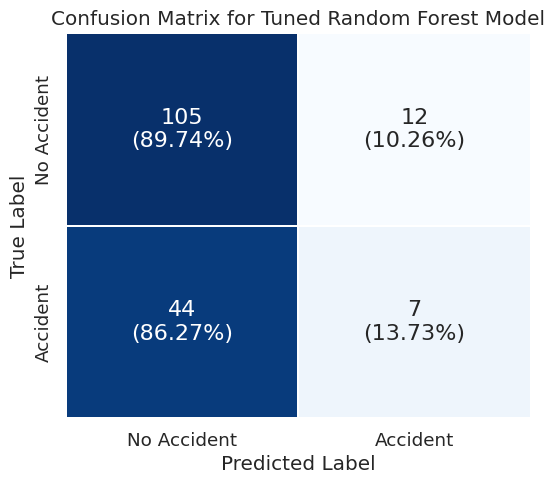


ROC-AUC Score: 0.5440


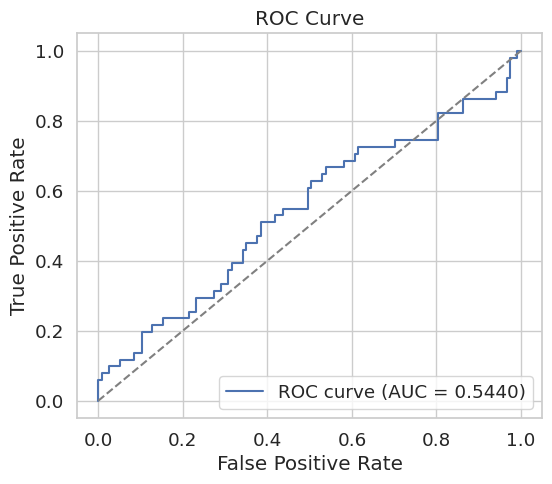

In [18]:
# Final Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 3. Make predictions using the tuned Random Forest model
y_pred_best = best_rf_model.predict(X_test_scaled)
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class ('Accident')

# Calculate accuracy on the test set
final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nFinal Model Accuracy on Test Set: {final_accuracy:.4f}")

# 4. Generate the classification report for detailed performance analysis
target_names = ['No Accident', 'Accident']  # Update this based on your dataset
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=target_names, zero_division=0))

# 5. Display the confusion matrix for additional evaluation
cm = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix as a heatmap with percentages

def plot_confusion_matrix_with_percentages(y_true, y_pred, target_names):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create a display matrix with counts and percentages
    cm_display = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cm_display[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.2f}%)"
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percentage, annot=cm_display, fmt='', cmap='Blues', xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={"size": 16}, linewidths=1.2)
    plt.title('Confusion Matrix for Tuned Random Forest Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Usage example with your data
target_names = ['No Accident', 'Accident']  # Update this based on your dataset
plot_confusion_matrix_with_percentages(y_test, y_pred_best, target_names)
# 6. ROC-AUC (Receiver Operating Characteristic Curve)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Best ROC-AUC Score on Training: 83.27%

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training Time: 46.39 seconds
Number of Training Iterations: 216

Training Score with Best Hyperparameters: 95.39%

Final Model Accuracy on Test Set: 0.7500

Classification Report:
              precision    recall  f1-score   support

 No Accident       0.75      0.97      0.84       117
    Accident       0.76      0.25      0.38        51

    accuracy                           0.75       168
   macro avg       0.76      0.61      0.61       168
weighted avg       0.75      0.75      0.70       168



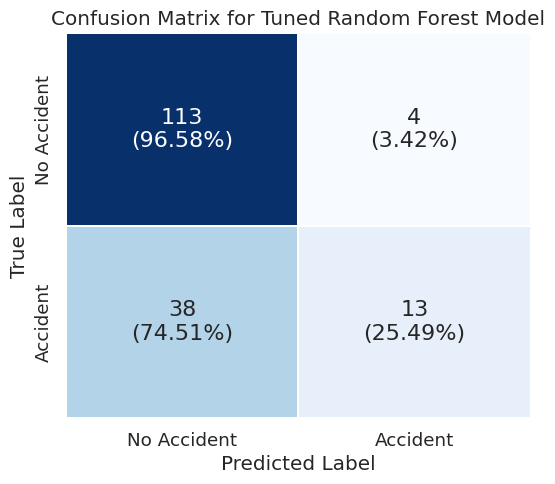


ROC-AUC Score: 0.5716


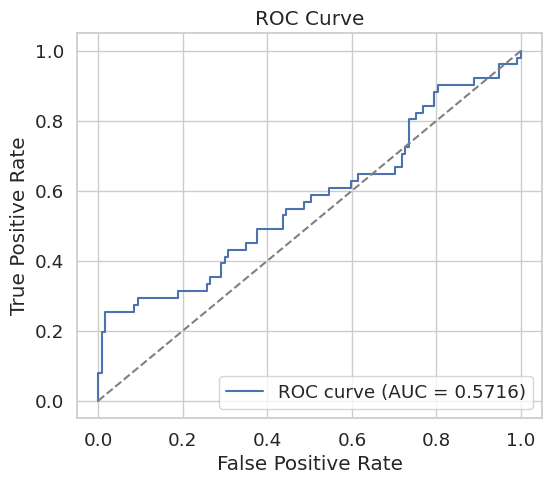

In [54]:
# re-hypertuning and model evaluation
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import time
#Apply SMOTE to Balance Classes in Training Data
# -------------------------------
# smote = SMOTE(random_state=40, sampling_strategy='auto')
# X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
# -------------------------------
# Hyperparameter Tuning with GridSearchCV (Modified to Reduce Overfitting)
# -------------------------------
# Adjust the grid to enforce shallower trees and larger leaf sizes for better generalization.
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees in the forest
    'max_depth': [5, 10],                       # Limit tree depth to reduce overfitting
    'criterion': ['gini', 'entropy'],           # Splitting criterion
    'max_features': ['sqrt', 'log2', None],     # Number of features to consider for splitting
    'min_samples_split': [5, 10],               # Higher minimum samples to split a node
    'min_samples_leaf': [2, 3, 4]                # Higher minimum samples for each leaf
}

# Initialize Random Forest with balanced class weights
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=40)

# Use StratifiedKFold for cross-validation to ensure each fold has similar class distribution
cv = StratifiedKFold(n_splits=3)

# Use GridSearchCV with ROC-AUC as the scoring metric to directly optimize for model discrimination
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Run grid search on the resampled training data
start_time = time.time()
grid_search.fit(X_train_res, y_train_res)
end_time = time.time()

# Display the best hyperparameters and training details
results_df = pd.DataFrame(grid_search.cv_results_)
print(f"Best ROC-AUC Score on Training: {grid_search.best_score_:.2%}\n")
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Training Time: {round(end_time - start_time, 2)} seconds")
print("Number of Training Iterations:", results_df.shape[0])

# Retrieve the best estimator and retrain on the entire (scaled) training set
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)
train_score = best_rf_model.score(X_train_scaled, y_train)
print(f"\nTraining Score with Best Hyperparameters: {train_score:.2%}")

# -------------------------------
# Final Model Evaluation on Test Set
# -------------------------------
# Make predictions on the test set
y_pred_best = best_rf_model.predict(X_test_scaled)
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class ("Accident")

# Calculate final accuracy on the test set
final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nFinal Model Accuracy on Test Set: {final_accuracy:.4f}")

# Generate and display the classification report (includes precision, recall, and F1-score)
target_names = ['No Accident', 'Accident']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=target_names, zero_division=0))

# -------------------------------
# Plot Confusion Matrix with Percentages
# -------------------------------
def plot_confusion_matrix_with_percentages(y_true, y_pred, target_names):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Calculate row-wise percentages (each row sums to 100%)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    # Create a display matrix combining counts and percentages
    cm_display = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cm_display[i, j] = f"{cm[i, j]}\n({cm_percentage[i, j]:.2f}%)"
    # Plot the heatmap using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=cm_display, fmt='', cmap='Blues', xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={"size": 16}, linewidths=1.2)
    plt.title("Confusion Matrix for Tuned Random Forest Model")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(y_test, y_pred_best, target_names)

# -------------------------------
# Compute and Display ROC-AUC and ROC Curve
# -------------------------------
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve (False Positive Rate vs True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()
